In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.special
import scipy.fft
from operators.SW_sqrt import solve_poisson_equation_two_stream, psi_ln_sw, mass, momentum, energy_k

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib.pylab as pl
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Two-Stream Instability SW square-root

In [26]:
# set up configuration parameters
# number of mesh points in x 
Nx = 101
# number of spectral expansions
Nv = 101
# epsilon displacement in initial electron distribution 
epsilon = 1e-3
# velocity scaling of electron and ion
alpha_e1 = 0.5 
alpha_e2 = 0.5
alpha_i = np.sqrt(2/1863)
# x grid is from 0 to L
L = 2 * np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L/(Nx-1)
# final time (nondimensional)
T = 45
# velocity scaling 
u_e1 = 1
u_e2 = -1 
u_i = 0
# mass normalized
m_e1 = 1
m_e2 = 1
m_i = 1863
# charge normalized
q_e1 = -1
q_e2 = -1
q_i = 1

In [12]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(1e5))
# spatial grid 
x = np.linspace(0, L, Nx)

In [13]:
# initial condition of the first expansion coefficient
C_0e1 = np.sqrt(0.5 * (1 + epsilon * np.cos(x)) / alpha_e1)
C_0e2 = np.sqrt(0.5 * (1 + epsilon * np.cos(x)) / alpha_e2)
C_0i = np.sqrt(np.ones(Nx) / alpha_i)

In [14]:
# the distribution function of electrons and protons for plotting purposes
f_0e1 = np.outer(C_0e1, psi_ln_sw((v-u_e1)/alpha_e1, n=0))
f_0e2 = np.outer(C_0e2, psi_ln_sw((v-u_e2)/alpha_e2, n=0))
f_0i = np.outer(C_0i, psi_ln_sw((v-u_i)/alpha_i, n=0))

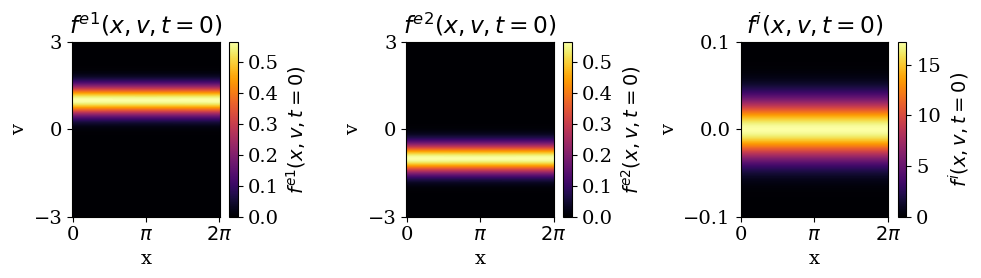

In [15]:
# plot initial condition 
fig, ax = plt.subplots(ncols=3, sharey=False, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, (f_0e1**2).T, cmap="inferno", vmin=0, vmax=np.max(f_0e1**2))
ax[0].set_xlabel("x")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.ax.set_ylabel('$f^{e1}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e1}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, (f_0e2**2).T, cmap="inferno", vmin=0, vmax=np.max(f_0e2**2))
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_xlabel("x")
ax[1].set_ylabel("v")
ax[1].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.ax.set_ylabel('$f^{e2}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{e2}(x, v, t=0)$")

pos = ax[2].pcolormesh(x, v, (f_0i**2).T, cmap="inferno")
ax[2].set_xticks([0, np.pi, 2*np.pi])
ax[2].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[2].set_xlabel("x")
ax[2].set_ylabel("v")
ax[2].set_yticks([-0.1, 0, 0.1])
ax[2].set_ylim(-0.1, 0.1)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[2].set_title("$f^{i}(x, v, t=0)$")

plt.tight_layout()
plt.savefig("../figs/SW_sqrt/two_stream/initial_condition_two_stream.png", dpi=600)

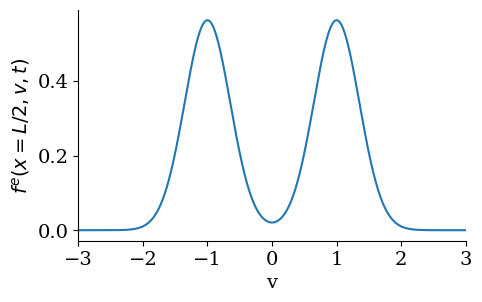

In [16]:
# plot initial condition vertical slice
fig, ax = plt.subplots(figsize=(5, 3))
_ = plt.plot(v, f_0e1[55, :]**2 + f_0e2[55, :]**2)
_ = ax.set_xlabel("v")
_ = ax.set_ylabel("$f^{e}(x= L/2, v, t)$")
_ = ax.set_xlim(v[0], v[-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [18]:
# load simulation data 
sol_midpoint_u = np.load("../data/SW_sqrt/two_stream/sol_midpoint_u_" + str(Nv) + ".npy")
sol_midpoint_t = np.load("../data/SW_sqrt/two_stream/sol_midpoint_t_" + str(Nv) + ".npy")

# print shape of simulation data 
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(20202, 4501)
(4501,)


In [19]:
# initialize electric field
E_midpoint = np.zeros((Nx, len(sol_midpoint_t)))

In [20]:
# initialize the states for implicit midpoint
state_e1_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_e2_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))


for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the Vlasov-Poisson system
        state_e1_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        state_e2_midpoint[jj, :, ii] = sol_midpoint_u[Nv*(Nx-1) + jj*(Nx-1): Nv*(Nx-1) + (jj+1)*(Nx-1), ii]
        # static/background ions
        state_i_midpoint[0, :, ii] = np.sqrt(np.ones(Nx - 1) / alpha_i)

    # solve Poisson's equation 
    E_midpoint[:-1, ii] = solve_poisson_equation_two_stream(state_e1=state_e1_midpoint[:, :, ii], 
                                           state_e2=state_e2_midpoint[:, :, ii],
                                           state_i=state_i_midpoint[:, :, ii], 
                                           alpha_e1=alpha_e1, 
                                           alpha_e2=alpha_e2, 
                                           alpha_i=alpha_i, 
                                           dx=dx, L=L)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

In [21]:
# save electric field
np.save("../data/SW_sqrt/two_stream/sol_midpoint_e_" + str(Nv) + ".npy", E_midpoint)

In [22]:
# compute electric field growth rate
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

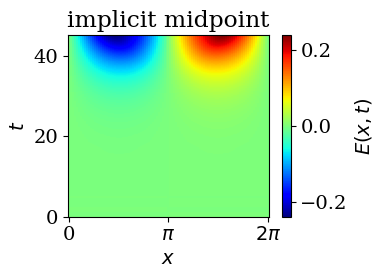

In [23]:
# plot electric field evolution 
fig, ax = plt.subplots(figsize=(4, 3))
pos = ax.pcolormesh(x, sol_midpoint_t, E_midpoint.T, cmap="jet")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("implicit midpoint")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/two_stream/two_stream_electric_field.png", dpi=600)

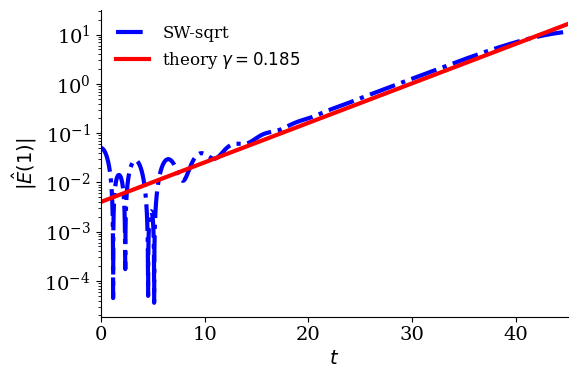

In [27]:
# plot electric field growth rate
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, E1_midpoint, "-.", c="blue", linewidth=3, label="SW-sqrt")
ax.plot(sol_midpoint_t, np.exp(0.185*sol_midpoint_t)*(4e-3), linewidth=3, color="red", label=r"theory $\gamma = 0.185$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/two_stream/two_stream_electric_field.png", dpi=600)

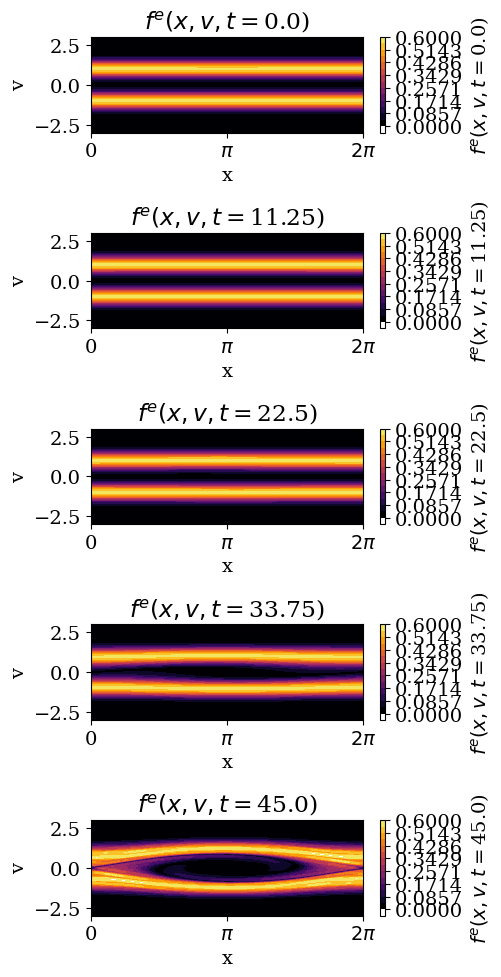

In [33]:
# plot phase space evolution 
fig, ax = plt.subplots(nrows=5, figsize=(5, 10))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)//4))):
    distribution1 = np.zeros((Nx, len(v)))
    distribution2 = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution2 += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj))
        distribution1 += np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj))
    levels = np.append(-0.1, np.linspace(0, 0.6, 15))
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
    pos = ax[tt].contourf(x, v, (distribution1**2 + distribution2**2).T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xlabel("x")
    ax[tt].set_xticks([0, np.pi, 2*np.pi])
    ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(round(sol_midpoint_t[ii], 2)) + ")")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/two_stream/two_stream_evolution.png", dpi=600)

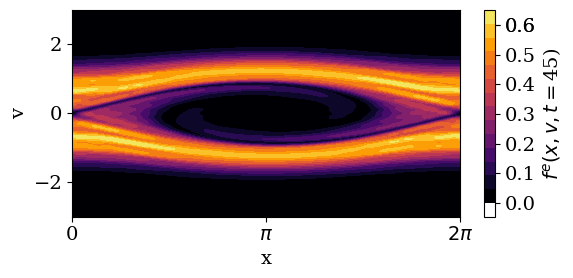

In [35]:
# plot the last timestamp electron distribution function in phase space 
fig, ax = plt.subplots(figsize=(6, 3))
ii = -1
distribution1 = np.zeros((Nx, len(v)))
distribution2 = np.zeros((Nx, len(v)))
for jj in range(Nv):
    distribution1 += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj))
    distribution2 += + np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj))

levels = np.append(-0.1, np.linspace(0, 0.65, 15))
colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
pos = ax.contourf(x, v, (distribution1**2 + distribution2**2).T, levels=levels, colors=np.append(["w"], colors))
ax.set_xlabel("x")
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(sol_midpoint_t[ii])) + ")", rotation=90)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
#cbar.ax.set_ylim(0, 0.6)
ax.set_ylim(-3, 3)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/two_stream/two_stream_electron_distribution_t_45_SW_sqrt_" + str(Nv) + ".png", dpi=600)

In [51]:
# save distribution at the last timestamp
distribution = (distribution1**2 + distribution2**2)
np.save("../data/SW_sqrt/two_stream/distribution_45_Nv_"+ str(Nv) + ".npy", distribution)

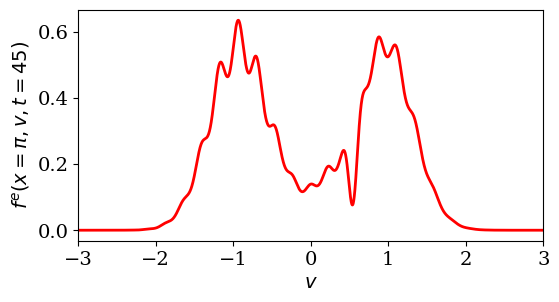

In [53]:
fig, ax = plt.subplots(figsize=(6, 3))
_ = ax.plot(v, distribution[20, :], c="r", linewidth=2)
_ = ax.set_xlim(-3, 3)
_ = ax.set_xlabel("$v$")
_ = ax.set_ylabel("$f^e(x=\pi, v, t=45)$")

# conservation laws: mass, momentum, and energy 

### mass conservation

In [54]:
# compute mass evolution 
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = mass(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv)\
                      + mass(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv)\
                      + mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

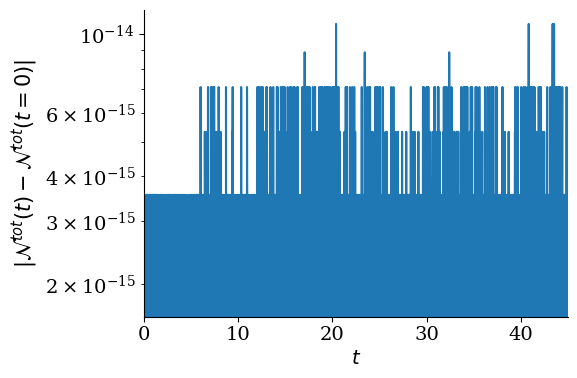

In [55]:
# plot mass evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation 

In [56]:
# momentum evolution 
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = momentum(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv, u_s=u_e1, m_s=m_e1)\
                           +momentum(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv, u_s=u_e2, m_s=m_e2)\
                           +momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, u_s=u_i, m_s=m_i)

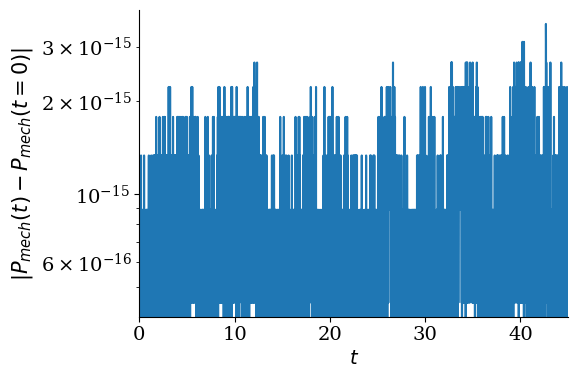

In [57]:
# plot momentum evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [74]:
# compute kinetic + potential energy evolution 
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = energy_k(state=state_e1_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_e1, m_s=m_e1, dx=dx, u_s=u_e1)\
                           +energy_k(state=state_e2_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_e2, m_s=m_e2, dx=dx, u_s=u_e2)\
                           +energy_k(state=state_i_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_i, m_s=m_i, dx=dx, u_s=u_i)
    
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:-1, ii])**2)

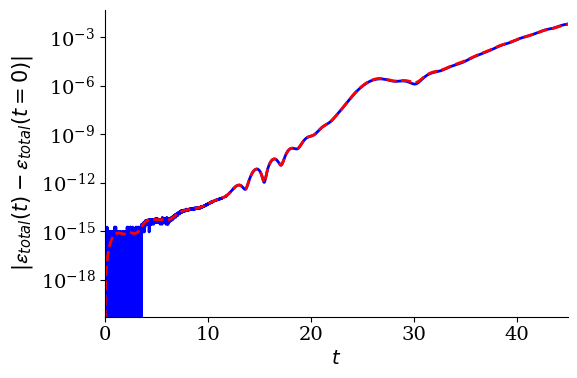

In [75]:
# plot energy evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-", color="blue", linewidth=2, label="numerical")
ax.plot(sol_midpoint_t, sol_midpoint_u[-1, :], ls="--", color="red", linewidth=2, label="analytic")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
plt.tight_layout()

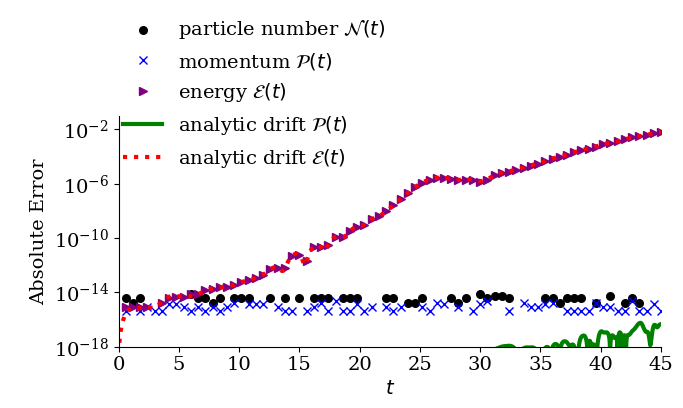

In [83]:
# plot overall conservation properties
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))

ax.scatter(sol_midpoint_t[::60], np.abs(mass_midpoint-mass_midpoint[0])[::60], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::60], np.abs(momentum_midpoint-momentum_midpoint[0])[::60], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::60], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::60], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")
ax.set_ylim(10**-18, 10**-1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fontsize=14, loc='upper center', bbox_to_anchor=(0.25, 1.5))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW_sqrt/two_stream/conservation_" + str(Nv) + "_two_stream_SW_sqrt.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)